# Self-Attention Mathematics: Step-by-Step Guide

This notebook provides a detailed explanation of the self-attention mechanism, breaking down the mathematics behind Query (Q), Key (K), and Value (V) matrices.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_style('whitegrid')
torch.manual_seed(42)

## 1. Understanding the Input

Let's start with a simple sentence and create token embeddings.

In [2]:
# Simple example: "The cat sat"
seq_len = 3
d_model = 4  # Small dimension for clarity

# Create simple token embeddings (normally from embedding layer)
X = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],  # "The"
    [0.0, 1.0, 0.0, 1.0],  # "cat"
    [1.0, 1.0, 0.0, 0.0]   # "sat"
])

print("Input Embeddings (X):")
print(X)
print(f"\nShape: {X.shape} (seq_len={seq_len}, d_model={d_model})")

Input Embeddings (X):
tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 0., 0.]])

Shape: torch.Size([3, 4]) (seq_len=3, d_model=4)


## 2. Creating Query, Key, and Value Matrices

The core of attention is projecting the input into three different spaces:
- **Query (Q)**: What am I looking for?
- **Key (K)**: What do I contain?
- **Value (V)**: What information do I have to offer?

In [3]:
# Initialize weight matrices (in practice, these are learned)
W_q = torch.randn(d_model, d_model) * 0.1
W_k = torch.randn(d_model, d_model) * 0.1
W_v = torch.randn(d_model, d_model) * 0.1

print("Weight Matrices:")
print(f"W_q shape: {W_q.shape}")
print(f"W_k shape: {W_k.shape}")
print(f"W_v shape: {W_v.shape}")

Weight Matrices:
W_q shape: torch.Size([4, 4])
W_k shape: torch.Size([4, 4])
W_v shape: torch.Size([4, 4])


In [4]:
# Compute Q, K, V by matrix multiplication
Q = X @ W_q  # Query: what each token is looking for
K = X @ W_k  # Key: what each token represents
V = X @ W_v  # Value: what information each token carries

print("Query Matrix (Q):")
print(Q)
print(f"\nKey Matrix (K):")
print(K)
print(f"\nValue Matrix (V):")
print(V)

Query Matrix (Q):
tensor([[ 0.1175,  0.3136,  0.0508, -0.3509],
        [-0.0049, -0.1794, -0.0812, -0.0842],
        [ 0.2605,  0.0253,  0.0858, -0.3710]])

Key Matrix (K):
tensor([[ 0.2921,  0.1137,  0.0113,  0.1774],
        [-0.0990,  0.1120,  0.0549,  0.2540],
        [ 0.0884,  0.0919,  0.0303,  0.2120]])

Value Matrix (V):
tensor([[-0.2942,  0.0124, -0.1103,  0.1116],
        [-0.0955,  0.1698, -0.0929, -0.1263],
        [-0.1066, -0.1296,  0.0082,  0.0943]])


## 3. Computing Attention Scores

Calculate how much each token should attend to every other token.

**Formula**: $\text{scores} = \frac{Q \cdot K^T}{\sqrt{d_k}}$

In [5]:
# Step 1: Compute raw attention scores (Q @ K^T)
d_k = d_model  # In our case, they're the same
raw_scores = Q @ K.transpose(-2, -1)

print("Raw Attention Scores (Q @ K^T):")
print(raw_scores)
print(f"\nShape: {raw_scores.shape}")
print("\nInterpretation: Element (i,j) = how much token i attends to token j")

Raw Attention Scores (Q @ K^T):
tensor([[ 0.0083, -0.0629, -0.0337],
        [-0.0377, -0.0455, -0.0372],
        [ 0.0141, -0.1125, -0.0507]])

Shape: torch.Size([3, 3])

Interpretation: Element (i,j) = how much token i attends to token j


In [6]:
# Step 2: Scale by sqrt(d_k) to prevent large values
import math

scaled_scores = raw_scores / math.sqrt(d_k)

print(f"Scaled Attention Scores (divided by sqrt({d_k}) = {math.sqrt(d_k):.2f}):")
print(scaled_scores)
print("\nScaling prevents gradient vanishing in softmax")

Scaled Attention Scores (divided by sqrt(4) = 2.00):
tensor([[ 0.0041, -0.0314, -0.0168],
        [-0.0189, -0.0227, -0.0186],
        [ 0.0071, -0.0563, -0.0254]])

Scaling prevents gradient vanishing in softmax


## 4. Applying Softmax to Get Attention Weights

Convert scores to probabilities that sum to 1 for each token.

In [7]:
# Apply softmax to each row
attention_weights = F.softmax(scaled_scores, dim=-1)

print("Attention Weights (after softmax):")
print(attention_weights)
print(f"\nRow sums (should be 1.0): {attention_weights.sum(dim=-1)}")

Attention Weights (after softmax):
tensor([[0.3396, 0.3278, 0.3326],
        [0.3337, 0.3324, 0.3338],
        [0.3440, 0.3229, 0.3331]])

Row sums (should be 1.0): tensor([1.0000, 1.0000, 1.0000])


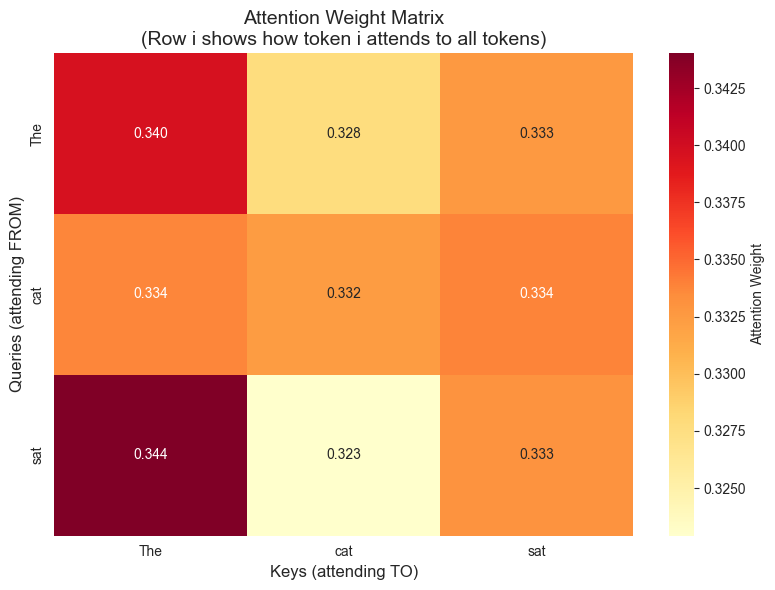

In [8]:
# Visualize attention weights
plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights.numpy(), 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd',
            xticklabels=['The', 'cat', 'sat'],
            yticklabels=['The', 'cat', 'sat'],
            cbar_kws={'label': 'Attention Weight'})
plt.title('Attention Weight Matrix\n(Row i shows how token i attends to all tokens)', fontsize=14)
plt.xlabel('Keys (attending TO)', fontsize=12)
plt.ylabel('Queries (attending FROM)', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Computing the Final Attention Output

Weighted sum of values using attention weights.

**Formula**: $\text{output} = \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

In [9]:
# Multiply attention weights with values
attention_output = attention_weights @ V

print("Attention Output:")
print(attention_output)
print(f"\nShape: {attention_output.shape}")
print("\nEach row is a weighted combination of all value vectors")

Attention Output:
tensor([[-0.1667,  0.0168, -0.0652,  0.0279],
        [-0.1655,  0.0174, -0.0649,  0.0268],
        [-0.1676,  0.0160, -0.0652,  0.0290]])

Shape: torch.Size([3, 4])

Each row is a weighted combination of all value vectors


## 6. Complete Self-Attention Function

Let's put it all together in a single function.

In [10]:
def self_attention(X, W_q, W_k, W_v, mask=None):
    """
    Complete self-attention mechanism
    
    Args:
        X: Input embeddings (seq_len, d_model)
        W_q, W_k, W_v: Weight matrices
        mask: Optional attention mask
    
    Returns:
        output: Attention output
        attention_weights: Attention distribution
    """
    # Step 1: Project to Q, K, V
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v
    
    # Step 2: Compute scaled attention scores
    d_k = Q.size(-1)
    scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Step 3: Apply mask (if provided)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Step 4: Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 5: Compute weighted sum of values
    output = attention_weights @ V
    
    return output, attention_weights

# Test the function
output, weights = self_attention(X, W_q, W_k, W_v)
print("Self-Attention Output:")
print(output)
print(f"\nMatches previous computation: {torch.allclose(output, attention_output)}")

Self-Attention Output:
tensor([[-0.1667,  0.0168, -0.0652,  0.0279],
        [-0.1655,  0.0174, -0.0649,  0.0268],
        [-0.1676,  0.0160, -0.0652,  0.0290]])

Matches previous computation: True


## 7. Understanding Masking (Optional)

Masks prevent attention to certain positions (e.g., future tokens in autoregressive models).

In [11]:
# Create a causal mask (lower triangular)
causal_mask = torch.tril(torch.ones(seq_len, seq_len))

print("Causal Mask (prevents attending to future tokens):")
print(causal_mask)

# Apply masked attention
masked_output, masked_weights = self_attention(X, W_q, W_k, W_v, mask=causal_mask)

print("\nMasked Attention Weights:")
print(masked_weights)

Causal Mask (prevents attending to future tokens):
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

Masked Attention Weights:
tensor([[1.0000, 0.0000, 0.0000],
        [0.5010, 0.4990, 0.0000],
        [0.3440, 0.3229, 0.3331]])


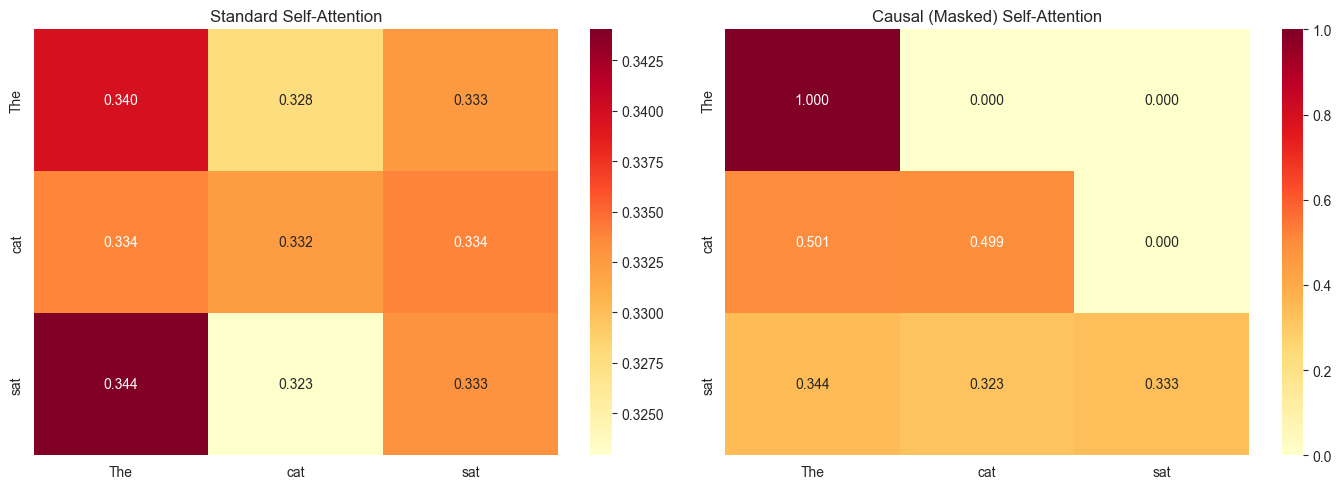

In [12]:
# Visualize masked attention
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original attention
sns.heatmap(attention_weights.numpy(), 
            annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['The', 'cat', 'sat'],
            yticklabels=['The', 'cat', 'sat'],
            ax=axes[0])
axes[0].set_title('Standard Self-Attention', fontsize=12)

# Masked attention
sns.heatmap(masked_weights.numpy(), 
            annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['The', 'cat', 'sat'],
            yticklabels=['The', 'cat', 'sat'],
            ax=axes[1])
axes[1].set_title('Causal (Masked) Self-Attention', fontsize=12)

plt.tight_layout()
plt.show()

## 8. Key Intuitions

### What did we learn?

1. **Query (Q)**: Represents what each token is "searching for"
2. **Key (K)**: Represents what each token "offers" or "contains"
3. **Value (V)**: The actual information to be aggregated

### The Attention Mechanism:
- **Scores**: Dot product between queries and keys measures relevance
- **Scaling**: Dividing by √d_k stabilizes gradients
- **Softmax**: Converts scores to a probability distribution
- **Output**: Weighted combination of values based on attention

### Why is this powerful?
- **Dynamic**: Each token can attend to any other token
- **Contextual**: Representations depend on the entire sequence
- **Parallelizable**: All computations can be done simultaneously
- **Learnable**: Q, K, V projections are learned from data

## 9. Multi-Head Attention Preview

In practice, we use multiple attention heads to capture different types of relationships.

In [13]:
# Simulate 2 attention heads
num_heads = 2
d_k = d_model // num_heads

print(f"Original dimension: {d_model}")
print(f"Number of heads: {num_heads}")
print(f"Dimension per head: {d_k}")
print("\nEach head learns different attention patterns!")
print("- Head 1 might focus on syntax (e.g., subject-verb agreement)")
print("- Head 2 might focus on semantics (e.g., word meanings)")

Original dimension: 4
Number of heads: 2
Dimension per head: 2

Each head learns different attention patterns!
- Head 1 might focus on syntax (e.g., subject-verb agreement)
- Head 2 might focus on semantics (e.g., word meanings)


## Summary

**Self-Attention Formula**:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q = XW_q$ (Queries)
- $K = XW_k$ (Keys)
- $V = XW_v$ (Values)

This mechanism allows each position in a sequence to attend to all positions, creating rich contextual representations!